# Benchmarks for cold-start

The idea is to compare DPP / random / mosaïque for the selection of the first items to rate for a newcomer.

## Preliminaries: DPP sampling

Load vectors from the saved SVD

In [1]:
from mangaki.utils.data import Dataset
dataset = Dataset()

In [2]:
from mangaki.utils.svd import MangakiSVD
algo = MangakiSVD()
algo.load(algo.get_backup_filename())  # Trained on everything
dataset.load('ratings-' + algo.get_backup_filename())

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jin/Sites/mangaki/mangaki/../pickles/svd-10.pickle'

In [4]:
import numpy as np
rated_by_jj = np.array(User.objects.get(id=1).rating_set.values_list('work', 'work__title', 'choice'), dtype=[('work_id', 'i2'), ('work_title', 'U128'), ('choice', 'S8')])

In [5]:
rated_works = rated_by_jj['work_id']
encoded_work_ids = dataset.encode_works(rated_works)

In [6]:
vectors = algo.VT.T[encoded_work_ids]
L = vectors.dot(vectors.T)

In [7]:
D, V = np.linalg.eig(L.T)
D = np.real(D)
V = np.real(V)

If we want to summarize JJ's profile, which ratings should we keep?

In [8]:
from mangaki.utils import dpplib
sampled_indices = list(map(int, dpplib.sample_k(5, D, V)))
print(rated_by_jj[sampled_indices])
dpp_works = rated_works[sampled_indices]

def get_dpp_works(k):
    sampled_indices = list(map(int, dpplib.sample_k(k, D, V)))
    # print(rated_by_jj[sampled_indices])
    return rated_works[sampled_indices]

import random
def get_random_works(k):
    return np.array(random.sample(list(rated_works), k))

[(  34, 'K-On!', b'wontsee') (   9, 'Elfen Lied', b'willsee')
 ( 150, 'Danshi Koukousei no Nichijou', b'willsee')
 (1973, 'Fate/stay night: Unlimited Blade Works (TV) - Prologue', b'willsee')
 (1563, 'Ponyo sur la falaise', b'like')]


## Simulation

In [17]:
print(Rating.objects.filter(user_id=1).count(), 'ratings for JJ')
ds = Dataset()
anonymized = ds.make_anonymous_data(Rating.objects.all())

536 ratings for JJ


In [18]:
def select_works_to_rate():
    if METHOD == 'dpp':
        kept_works = get_dpp_works(NB_WORKS)
    else:
        kept_works = get_random_works(NB_WORKS)
    return kept_works

In [19]:
def split_train_test(kept_works):
    i_train = []
    i_test = []
    my_encoded_user_id = ds.encode_user[1]
    encoded_kept_works = set(ds.encode_works(kept_works))
    for i, (encoded_user_id, encoded_work_id) in enumerate(anonymized.X):
        if encoded_user_id == my_encoded_user_id and encoded_work_id not in encoded_kept_works:
            i_test.append(i)
        else:
            i_train.append(i)
    return i_train, i_test

In [34]:
from mangaki.utils.knn import MangakiKNN
from sklearn.metrics import mean_squared_error
def compute_error(i_train, i_test):
    knn = MangakiKNN(40)
    knn.set_parameters(anonymized.nb_users, anonymized.nb_works)
    knn.fit(anonymized.X[i_train], anonymized.y[i_train])
    my_encoded_user_id = ds.encode_user[1]
    neighbors = knn.get_neighbors([my_encoded_user_id])[0]
    # print([User.objects.get(id=user_id) for user_id in ds.decode_users(neighbors)])
    y_pred = knn.predict(anonymized.X[i_test])
    print('predicted:', y_pred[:5])
    print('was:', anonymized.y[i_test][:5])
    rmse = mean_squared_error(anonymized.y[i_test], y_pred) ** 0.5
    print('rmse:', rmse)
    top_pred_indices = y_pred.argsort()[-20:]
    # top_pred_indices = anonymized.y[i_test].argsort()[-20:]
    print('predicted:', y_pred[top_pred_indices])
    print('was:', anonymized.y[i_test][top_pred_indices])
    rmse = mean_squared_error(anonymized.y[i_test][top_pred_indices], y_pred[top_pred_indices]) ** 0.5
    print('rmse:', rmse)
    for work_id in [ds.decode_work[encoded_work_id] for _, encoded_work_id in anonymized.X[i_test][top_pred_indices]]:
        print(Work.objects.get(id=work_id).title)
    # print('full predict')
    # knn.predict(np.array([(1522, ds.encode_work[13811])]), True)
    return rmse

In [41]:
def run_simulation():
    kept_works = select_works_to_rate()
    i_train, i_test = split_train_test(kept_works)
    print('train size', len(i_train))
    print('test size', len(i_test))
    rmse = compute_error(i_train, i_test)
    print(NB_WORKS, METHOD, rmse)

## Results (number of works asked, strategy, RMSE)

- 10 DPP 1.09488816919 1.1020390692
- 20 DPP 1.0957652159900086
- 50 DPP 1.06436560838
- 100 DPP 1.0724727205
- 500 DPP 1.27818830679 0.848657862475 (possibly overfitting)

- 10 RND 1.09689215268 1.08273857127
- 20 RND 1.11930399192
- 50 RND 1.06455730002
- 100 RND 1.06357987938
- 500 RND 0.825381153284 0.754057572138

In [42]:
NB_WORKS = 10
METHOD = 'dpp'

In [43]:
run_simulation()

train size 317355
test size 526
[array([ 855,  279, 1050,  873, 1155, 1799,  103,  893, 1892,  745, 1761,
       1235,  101, 1239,  406, 1567,  634, 1441,  438, 1244, 1134, 1664,
        610,  169,  912, 1222,  129, 1687,  159,  407,  758,  593,  962,
        551, 1323,  785,  570, 1485, 1814, 1401])]
predicted: [ 0.  0.  0.  0.  0.]
was: [-0.5 -0.5 -0.5  0.5  0.5]
rmse: 1.23206181617
predicted: [ 1.14453807  1.14509658  1.15560294  1.16562679  1.20279494  1.22436833
  1.22739906  1.26143443  1.26331597  1.2685274   1.31005521  1.31468137
  1.39853659  1.42103941  1.43096924  1.6688064   1.68547088  1.70220729
  1.72033654  1.72612439]
was: [ 0.5  2.   2.  -0.5  4.   0.5  4.   2.   2.   2.   2.   0.5  0.1  4.   2.
  0.5  0.5  2.   4.   2. ]
rmse: 1.41820288426
Angel Beats!
Mahou Shoujo Madoka★Magica
Toki wo Kakeru Shoujo
Kill la Kill
Suzumiya Haruhi no Yuuutsu
Fullmetal Alchemist
Les Enfants Loups : Ame & Yuki
Code Geass: Hangyaku no Lelouch R2
Durarara!!
Nausicaä of the Valley of the 

Still needs to be done:
- run simulation on several users (how many works should be kept?)
- try a different number of neighbors
- should we evaluate the strategy on the whole profile or just the top recommendations?
- try other models than MangakiKNN (but others are slow)

## SVD

In [14]:
encoded_user_id = dataset.encode_work[1]
X_test = np.array([(encoded_user_id, dataset.encode_work[work_id]) for work_id in rated_works])

In [23]:
y_pred = algo.predict(X_test)
top_recommended = y_pred.argsort()[-10:]
for i in top_recommended:
    print(rated_by_jj[i])

(1, 'Death Note', b'like')
(13, 'Code Geass: Hangyaku no Lelouch R2', b'like')
(2, 'Code Geass: Hangyaku no Lelouch', b'neutral')
(5, "L'Attaque des Titans", b'like')
(127, 'Hunter x Hunter', b'wontsee')
(2417, "Kuroko's Basketball 2", b'willsee')
(9385, 'Parasyte -the maxim-', b'willsee')
(107, 'Kuroko no Basket', b'willsee')
(7, 'Fullmetal Alchemist: Brotherhood', b'willsee')
(46, 'Psycho-Pass', b'willsee')


In [21]:
rated_works[top_recommended], y_pred[top_recommended]

(array([   1,   13,    2,    5,  127, 2417, 9385,  107,    7,   46], dtype=int16),
 array([ 1.6811598 ,  1.76624399,  1.76966227,  1.83171241,  1.85026713,
         1.8516618 ,  1.90392899,  2.01091566,  2.07686592,  2.4513739 ]))

In [68]:
from mangaki.utils.values import rating_values
y_test = np.array(list(map(lambda x: rating_values[x.decode('utf-8')], rated_by_jj['choice'])))

In [37]:
rmse = mean_squared_error(y_test, y_pred) ** 0.5
rmse

1.3342711646750836

In [61]:
from sklearn.linear_model import LinearRegression
clf = LinearRegression(fit_intercept=False)

In [46]:
X_reg = algo.VT.T[dataset.encode_works(rated_works)]
clf.fit(X_reg, y_test)

/Users/jin/Sites/mangaki/venv/lib/python3.6/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [54]:
y_reg_pred = clf.predict(X_reg)
rmse = mean_squared_error(y_test, y_reg_pred) ** 0.5
rmse

1.0812074357558288

In [137]:
sampled_indices = list(map(int, dpplib.sample_k(20, D, V)))
print(sampled_indices)

[22, 171, 153, 250, 373, 251, 306, 442, 272, 291, 20, 331, 200, 301, 395, 341, 286, 375, 38, 258]


In [138]:
clf = LinearRegression(fit_intercept=False)
clf.fit(X_reg[sampled_indices], y_test[sampled_indices])
y_reg_pred = clf.predict(X_reg)
rmse = mean_squared_error(y_test, y_reg_pred) ** 0.5
rmse

2.9427890870750679

In [72]:
top_recommended = y_reg_pred.argsort()[-10:]
print(rated_by_jj[top_recommended])
bottom_recommended = y_reg_pred.argsort()[:10]
print(rated_by_jj[bottom_recommended])

[(  16, 'Steins;Gate', b'favorite') (  19, 'Mirai Nikki', b'willsee')
 (  46, 'Psycho-Pass', b'willsee') (  55, 'No Game No Life', b'favorite')
 (4369, "Attaque Des Titans (l')", b'willsee')
 (5001, 'Death note', b'like') (   1, 'Death Note', b'like')
 (   2, 'Code Geass: Hangyaku no Lelouch', b'neutral')
 (  13, 'Code Geass: Hangyaku no Lelouch R2', b'like')
 (   5, "L'Attaque des Titans", b'like')]
[(    8, 'Fullmetal Alchemist', b'willsee')
 (  195, 'Fullmetal Alchemist: Brotherhood OVA Collection', b'willsee')
 (   18, 'Fairy Tail', b'willsee')
 (    7, 'Fullmetal Alchemist: Brotherhood', b'willsee')
 (   17, 'Naruto: Shippuuden', b'wontsee')
 (  126, 'Dragon Ball GT', b'willsee')
 (  125, 'Fullmetal Alchemist: The Conqueror of Shamballa', b'willsee')
 (   27, 'One Piece', b'wontsee') (10505, 'Dog Days', b'willsee')
 (  844, 'Card Captor Sakura', b'favorite')]


In [100]:
sampled_indices = random.sample(range(len(rated_works)), 10)
clf = LinearRegression(fit_intercept=False)
clf.fit(X_reg[sampled_indices], y_test[sampled_indices])
y_reg_pred = clf.predict(X_reg)
rmse = mean_squared_error(y_test, y_reg_pred) ** 0.5
rmse

2.3143075293148456

## Clean SVD

In [3]:
from mangaki.utils.data import Dataset
from mangaki.utils.svd import MangakiSVD
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
import numpy as np
from mangaki.utils.dpp import MangakiProxyDPP
from sklearn.linear_model import LinearRegression, LogisticRegression
import random
import csv


dataset = Dataset()
# dataset.load('ratings-svd.pickle')
dataset.load_csv('ratings-ml.csv')

NB_COMPONENTS = 20
TEST_SIZE_RATE = 0.2

In [4]:
def get_train_test_stats(dataset):
    i_train, i_test = train_test_split(range(dataset.anonymized.nb_users), test_size=TEST_SIZE_RATE)
    r_train = []
    r_test = []
    inv_pos = {}
    user_test_set = set(i_test)
    nb_ratings = Counter()
    for r, (encoded_user_id, encoded_work_id) in enumerate(dataset.anonymized.X):
        inv_pos[(encoded_user_id, encoded_work_id)] = r
        if encoded_user_id in user_test_set:
            r_test.append(r)
        else:
            r_train.append(r)
            nb_ratings[encoded_work_id] += 1
#    popular_encoded_work_ids = get_popular(nb_ratings, NB_MOST_POPULAR)
    print('Rating test set rate', len(r_test) / len(dataset.anonymized.X))
    return i_test, r_train, r_test, nb_ratings, inv_pos

In [5]:
def get_popular_subset(nb_ratings, nb_most_popular):
    return np.array([work_id for work_id, _ in nb_ratings.most_common(nb_most_popular)])

In [6]:
def get_truth_dict(dataset, r_test):
    truth = defaultdict(dict)
    for r in r_test:
        user_id, work_id = dataset.anonymized.X[r]
        truth[user_id][work_id] = dataset.anonymized.y[r]
    return truth

In [7]:
def sample_questions(method, rated_works, nb_questions, dpp=None):
    if method == 'dpp':
        dpp.subset(rated_works)
        sampled_indices = dpp.sample_k(nb_questions)
    elif method == 'random':
        sampled_indices = random.sample(list(range(len(rated_works))), nb_questions)
    elif method == 'popular':
        sampled_indices = sorted(range(len(rated_works)), key=lambda i: nb_ratings[rated_works[i]], reverse=True)[:nb_questions]
    return sampled_indices

In [177]:
AVERAGE_RATING = 2.5

def collect_answers(all_vectors, asked_encoded_work_ids, user_truth, my_user_id, inv_pos):
    """print(sorted(user_truth.keys())[:5])
    print(sorted(asked_encoded_work_ids)[:5])"""
    X_vectors = []
    y = []
    y_binary = []
    r_bonus = []
    for encoded_work_id in sorted(asked_encoded_work_ids):
        choice = user_truth.get(encoded_work_id)
        if choice is not None:
            X_vectors.append(all_vectors[encoded_work_id])
            y.append(choice)
            y_binary.append(1 if choice > AVERAGE_RATING else -1)
            r_bonus.append(inv_pos[(my_user_id, encoded_work_id)])
    return X_vectors, y, y_binary, r_bonus

In [9]:
def validate_model(clf, all_vectors, user_truth, clf2=None):
    encoded_work_ids, true_choices = zip(*user_truth.items())
    encoded_work_ids = list(encoded_work_ids)
    pred_choices = clf.predict(all_vectors[encoded_work_ids])
    """print(pred_choices[:5])
    print(true_choices[:5])
    if clf2:
        print(clf2.predict(all_vectors[encoded_work_ids])[:5])"""
    return model.compute_rmse(pred_choices, true_choices)

In [229]:
from mangaki.utils.als import MangakiALS

NB_COMPONENTS = 20
model = MangakiALS(NB_COMPONENTS)
model.set_parameters(dataset.anonymized.nb_users, dataset.anonymized.nb_works)
i_test, r_train, r_test, nb_ratings, inv_pos = get_train_test_stats(dataset)
truth = get_truth_dict(dataset, r_test)

model.fit(dataset.anonymized.X[r_train], dataset.anonymized.y[r_train])
all_vectors = model.VT.T
print(all_vectors.shape, 'works in total')

Rating test set rate 0.1828126874925003
(9066, 20) works in total


In [230]:
similarity = model.M.T.dot(model.M)

In [268]:
print(i_test[:10])
[len(truth[user_id]) for user_id in i_test[:10]]

[205, 657, 223, 613, 468, 545, 100, 89, 529, 345]


[319, 205, 63, 201, 279, 98, 24, 55, 20, 20]

In [235]:
NB_MOST_POPULAR = 100  # None for all
work_subset = get_popular_subset(nb_ratings, NB_MOST_POPULAR)
vectors = all_vectors[work_subset]
# dpp = MangakiProxyDPP(model.M.T)
dpp = MangakiProxyDPP(all_vectors)

In [236]:
def get_volume(vectors):
    return np.linalg.det(vectors.dot(vectors.T))

In [237]:
# Test DPP
N = 10
K = 3
rated_works = np.array(list(range(N)))
from itertools import combinations
all_dets = []
for u in combinations(rated_works, K):
    all_dets.append(sorted(u))
all_dets.sort(key=lambda u: get_volume(all_vectors[rated_works[list(u)]]), reverse=True)
sampled_indices = sorted(sample_questions('random', rated_works, 3, dpp))
X = all_vectors[rated_works[sampled_indices]]
vol = np.linalg.det(X.dot(X.T))
print('vol', vol, 'rank', all_dets.index(sampled_indices))
sampled_indices = sorted(sample_questions('dpp', rated_works, 3, dpp))
X = all_vectors[rated_works[sampled_indices]]
vol = np.linalg.det(X.dot(X.T))
print('vol', vol, 'rank', all_dets.index(sampled_indices))

vol 0.275101245708 rank 56
vol 4.22752029084 rank 2


In [238]:
np.linalg.norm(model.VT[5])

30.294799835414469

In [239]:
print(model.VT.shape)
print(model.VT[:, None].shape)

(20, 9066)
(20, 1, 9066)


In [240]:
class MangakiNewUser:
    def __init__(self, model, my_user_id):
        self.user_id = my_user_id
        self.model = model
        # clf = LinearRegression(fit_intercept=False)
        # clf2 = LogisticRegression(fit_intercept=False)
        """if len(set(yl)) >= 2:
            happened += 1
            clf2 = LogisticRegression(fit_intercept=False)
            # clf.fit(X, y)
            clf2.fit(X, yl)
            clf.coef_ = clf2.coef_
            clf.intercept_ = 0."""

    def fit(self, work_ids, choices):
        # r_bonus
        # self.model = MangakiALS(NB_COMPONENTS)
        # self.model.set_parameters(dataset.anonymized.nb_users, dataset.anonymized.nb_works)
        # self.model.fit(dataset.anonymized.X[r_train + r_bonus], dataset.anonymized.y[r_train + r_bonus])
        mean = np.mean(choices)
        self.model.means[self.user_id] = mean
        bonus_ratings = {user_id: {work_id: choice - mean for work_id, choice in zip(work_ids, choices)}}
        self.model.fit_user(user_id, bonus_ratings)
    
    def predict(self, work_ids):
        return self.model.predict(np.array([[self.user_id, work_id] for work_id in work_ids]))

In [241]:
def printv(*s):
    if VERBOSE:
        print(*s)

In [275]:
COVERAGE_VALUES = [3, 5, 10, 20]
VERBOSE = False
values = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
c = 0
happened = 0
print(len(i_test), 'personnes à tester')
for user_id in i_test:
    cold_start = MangakiNewUser(model, user_id)
    # Know the truth
    user_truth = truth[user_id]
    encoded_work_ids, true_choices = zip(*user_truth.items())
    encoded_work_ids = list(encoded_work_ids)
    # Get minimal RMSE
    cold_start.fit(encoded_work_ids, true_choices)
    y_pred = cold_start.model.predict(np.array([[user_id, work_id] for work_id in encoded_work_ids]))
    rmse = model.compute_rmse(y_pred, true_choices)
    printv('Minimal RMSE', rmse)
    true_user_vector = cold_start.model.U[user_id].copy()
    
    for coverage in COVERAGE_VALUES:
        for METHOD in ['dpp', 'random', 'popular']:
            printv(METHOD, coverage, 'Q')
            c += 1
            
            rated_works = np.array(list(user_truth.keys()))
            printv('User', user_id, 'rated', len(rated_works), 'works')
            nb_questions = max(1, round(coverage * len(rated_works) / 100))
            printv('questions', nb_questions)
            sampled_indices = list(set(sample_questions(METHOD, rated_works, nb_questions, dpp)))
            # assert len(set(sampled_indices)) == len(sampled_indices)
            asked_encoded_work_ids = sorted(rated_works[sampled_indices])
            printv('work_ids', asked_encoded_work_ids[:5])
            printv('vol', METHOD, ':', get_volume(all_vectors[asked_encoded_work_ids]))
            """print(sampled_indices)
            print(len(user_truth.keys()), 'vus')"""
            X_vectors, y, y_binary, r_bonus = collect_answers(all_vectors, asked_encoded_work_ids, user_truth, user_id, inv_pos)
            printv(len(y), 'answers', y[:5])
            values['count'][METHOD][coverage].append(len(y))
            if not y:
                continue
            values['std'][METHOD][coverage].append(np.std(y))
            
            printv(len(r_bonus), 'bonus ratings')
            cold_start.fit(asked_encoded_work_ids, y)

            y_pred = cold_start.predict(encoded_work_ids)
            printv('pred', y_pred[:5])
            printv('true', true_choices[:5])
            rmse = model.compute_rmse(y_pred, true_choices)
            values['rmse'][METHOD][coverage].append(rmse)
            printv('RMSE', rmse)
            delta = np.linalg.norm(cold_start.model.U[user_id] - true_user_vector)
            printv('Delta', delta)
            values['delta'][METHOD][coverage].append(delta)

        """for key in values:
            print(key, np.mean(values[key][METHOD][coverage]))"""
# print('happened', happened, 'on', c, 'tries')

135 personnes à tester


In [247]:
print('user', user_id)
y_pred = model.predict(np.array([[user_id, work_id] for work_id in user_truth]))
# y_pred.shape
model.compute_rmse(y_pred, true_choices)
# true_choices

user 582


1.5801469661664793

In [165]:
my_mean = np.mean(list(user_truth.values()))
# cold_start.svd.means[user_id]

In [166]:
print(model.U[user_id])
model.means[user_id] = my_mean
bonus = {user_id: {work_id: user_truth[work_id] - my_mean for work_id in user_truth}}
model.fit_user(user_id, bonus)
print(model.U[user_id])
model.M = model.U.dot(model.VT)

[ 0.45849884  0.20295351  0.01060655 -0.14983525  0.15905869  0.03013105
  0.0355368   0.03880883 -0.08395405  0.04118043]
[ 0.32692894  0.1939145  -0.06209887 -0.03899118  0.11547404 -0.02862005
  0.09405135 -0.00727508  0.03293423 -0.08476905]


In [208]:
encoded_work_ids, true_choices = zip(*user_truth.items())
cold_start.fit(encoded_work_ids, true_choices)
y_pred = model.predict(np.array([[user_id, work_id] for work_id in encoded_work_ids]))
model.compute_rmse(y_pred, true_choices)

0.78020599438048166

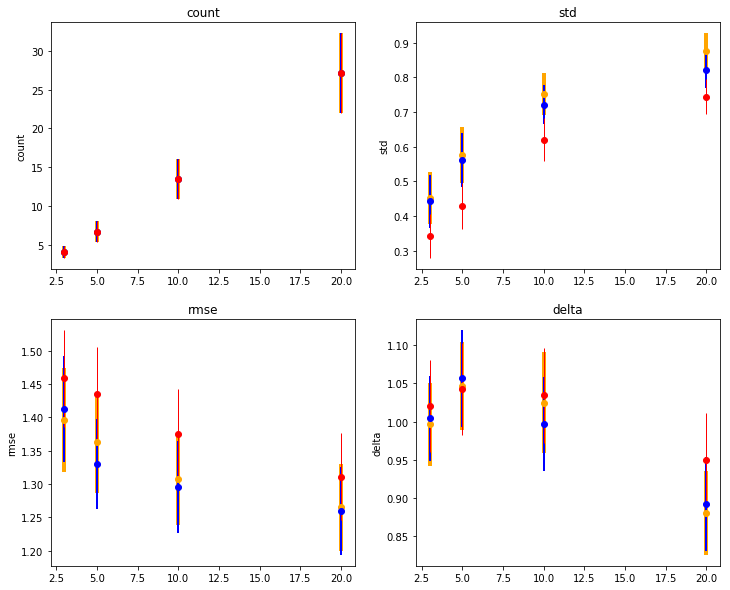

In [276]:
import matplotlib.pyplot as plt
from math import sqrt
size = {'dpp': 4, 'random': 2, 'popular': 1}
color = {'dpp': 'orange', 'random': 'blue', 'popular': 'red'}
plt.figure(figsize=(12, 10))
for i, key in enumerate(values, start=1):
    plt.subplot(2, 2, i)
    # plt.figure(key)
    for method in values[key]:
        plt.errorbar(x=COVERAGE_VALUES,
                     y=[np.mean(values[key][method][cov]) for cov in COVERAGE_VALUES],
                     yerr=[1.96 * np.std(values[key][method][cov]) / sqrt(len(values[key][method][cov])) for cov in COVERAGE_VALUES],
                     linewidth=size[method], fmt='o', color=color[method])
    plt.ylabel(key)
    plt.title(key)
plt.show()

In [250]:
print(np.mean(values['rmse']['dpp'][50]))
print(np.mean(values['rmse']['random'][50]))

1.36904813733
1.37515510523


In [90]:
my_user_id = i_test[5]
user_truth = truth[my_user_id]
len(user_truth)

378

In [30]:
cheat = MangakiSVD(NB_COMPONENTS)
cheat.set_parameters(dataset.anonymized.nb_users, dataset.anonymized.nb_works)
cheat.fit(dataset.anonymized.X, dataset.anonymized.y)

In [36]:
user_id = my_user_id
user_truth = truth[user_id]
print(len(user_truth), 'works rated')
encoded_work_ids, true_choices = zip(*user_truth.items())
encoded_work_ids = list(encoded_work_ids)
y_pred = cheat.predict(np.array([[user_id, work_id] for work_id in encoded_work_ids]))

82 works rated


In [37]:
cheat.compute_rmse(y_pred, true_choices)

0.63301128407480212

In [38]:
print(y_pred[:5])
print(true_choices[:5])

[ 4.01940583  3.75381313  3.83171     4.04327339  4.19463093]
(3.5, 3.0, 3.0, 4.0, 4.5)


In [33]:
y_pred = model.predict(np.array([[user_id, work_id] for work_id in encoded_work_ids]))
model.compute_rmse(y_pred, true_choices)

3.9911653488413967

In [34]:
print(y_pred[:5])
print(true_choices[:5])

[ 0.14470261 -0.41395963  0.48651871 -0.31400844 -0.44509364]
(3.5, 3.0, 3.0, 4.0, 4.5)


In [42]:
y_pred = clf.predict(all_vectors[encoded_work_ids])
print(y_pred[:5])
print(true_choices[:5])
model.compute_rmse(y_pred, true_choices)

[ 0.96141088  4.69114602  0.18369855  3.11130014  5.41268555]
(5.0, 4.0, 3.5, 5.0, 3.0)


4.9046470284311035

In [74]:
r_bonus = []
for r, (user_id, work_id) in enumerate(dataset.anonymized.X):
    if user_id == my_user_id:
        r_bonus.append(r)

big = MangakiSVD(NB_COMPONENTS)
big.set_parameters(dataset.anonymized.nb_users, dataset.anonymized.nb_works)
big.fit(dataset.anonymized.X[r_train + r_bonus], dataset.anonymized.y[r_train + r_bonus])

/Users/jin/Sites/mangaki/mangaki/mangaki/utils/svd.py:41: RuntimeWarning: invalid value encountered in double_scalars
  means[i] = np.sum(matrix[i]) / np.sum(matrix[i] != 0)


In [76]:
y_pred = big.predict(np.array([[user_id, work_id] for work_id in encoded_work_ids]))
print(y_pred[:15])
print(true_choices[:15])
big.compute_rmse(y_pred, true_choices)

[ 3.89258514  3.9176222   3.91470092  3.98430355  3.89990882  3.98331349
  4.01747955  4.06884564  3.97676186  3.79887259  3.81377788  3.93377835
  3.89652672  3.88009859  3.79983996]
(3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 4.0, 3.0, 2.0, 3.0, 4.0, 1.0, 3.0)


0.83551021742139298